<a href="https://colab.research.google.com/github/Morphling89/CNNs/blob/master/Copy_of_shonenkov_training_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
!python pytorch-xla-env-setup.py --version 20200601 --apt-packages libomp5 libopenblas-dev > /dev/null
!pip install transformers==2.5.1 > /dev/null
!pip install pandarallel > /dev/null
!pip install catalyst==20.4.2 > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  25380      0 --:--:-- --:--:-- --:--:-- 25380
Copying gs://tpu-pytorch/wheels/torch-nightly+20200601-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 90.2 MiB/ 90.2 MiB]                                                
Operation completed over 1 objects/90.2 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200601-cp36-cp36m-linux_x86_64.whl...
- [1 files][121.3 MiB/121.3 MiB]                                                
Operation completed over 1 objects/121.3 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200601-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      
ERROR:

In [1]:
!pip install iterative-stratification


In [2]:
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import os,shutil
os.environ['XLA_USE_BF16'] = "1"

from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import sklearn

import time
import random
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

from transformers import BertModel, BertTokenizer
from transformers import XLMRobertaModel, XLMRobertaTokenizer,XLMRobertaConfig
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler
# import tensorflow as tf
import gc
import re

# !pip install nltk > /dev/null
import nltk
nltk.download('punkt')

from nltk import sent_tokenize

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=4, progress_bar=False)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
# if 'COLAB_TPU_ADDR' not in os.environ:
#   print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
# else:
#   tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
#   print ('TPU address is', tpu_address)
# tf.config.experimental_connect_to_host(tpu_address)

In [6]:
# %tensorflow_version 1.x

In [7]:
# print(tf.__version__)

In [8]:
# cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
# tf.tpu.experimental.initialize_tpu_system(cluster_resolver)

In [3]:
SEED = 42

MAX_LENGTH = 224
BACKBONE_PATH = 'xlm-roberta-large'
# ROOT_PATH = f'..'
ROOT_PATH = f'/content/drive/My Drive/Colab Notebooks/toxic_multi' # for colab
CHECKPOINT_PATH = f'/content/drive/My Drive/Colab Notebooks/toxic_multi/results'


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [4]:
from nltk import sent_tokenize
from random import shuffle
import random
import albumentations
from albumentations.core.transforms_interface import DualTransform, BasicTransform


LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

def get_sentences(text, lang='en'):
    return sent_tokenize(text, LANGS.get(lang, 'english'))

def exclude_duplicate_sentences(text, lang='en'):
    sentences = []
    for sentence in get_sentences(text, lang):
        sentence = sentence.strip()
        if sentence not in sentences:
            sentences.append(sentence)
    return ' '.join(sentences)

def clean_text(text, lang='en'):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = exclude_duplicate_sentences(text, lang)
    return text.strip()


class NLPTransform(BasicTransform):
    """ Transform for nlp task."""

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params

    def get_sentences(self, text, lang='en'):
        return sent_tokenize(text, LANGS.get(lang, 'english'))

class ShuffleSentencesTransform(NLPTransform):
    """ Do shuffle by sentence """
    def __init__(self, always_apply=False, p=0.5):
        super(ShuffleSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = self.get_sentences(text, lang)
        random.shuffle(sentences)
        return ' '.join(sentences), lang

class ExcludeDuplicateSentencesTransform(NLPTransform):
    """ Exclude equal sentences """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeDuplicateSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = []
        for sentence in self.get_sentences(text, lang):
            sentence = sentence.strip()
            if sentence not in sentences:
                sentences.append(sentence)
        return ' '.join(sentences), lang

class ExcludeNumbersTransform(NLPTransform):
    """ exclude any numbers """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeNumbersTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'[0-9]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

class ExcludeHashtagsTransform(NLPTransform):
    """ Exclude any hashtags with # """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeHashtagsTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'#[\S]+\b', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

class ExcludeUsersMentionedTransform(NLPTransform):
    """ Exclude @users """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeUsersMentionedTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'@[\S]+\b', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

class ExcludeUrlsTransform(NLPTransform):
    """ Exclude urls """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeUrlsTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'https?\S+', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [5]:
class SynthesicOpenSubtitlesTransform(NLPTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(SynthesicOpenSubtitlesTransform, self).__init__(always_apply, p)
        df = pd.read_csv(f'{ROOT_PATH}/input/open-subtitles-synthesic.csv', index_col='id')[['comment_text', 'toxic', 'lang']]
        df = df[~df['comment_text'].isna()]
        df['comment_text'] = df.parallel_apply(lambda x: clean_text(x['comment_text'], x['lang']), axis=1)
        df = df.drop_duplicates(subset='comment_text')
        df['toxic'] = df['toxic'].round().astype(np.int)

        self.synthesic_toxic = df[df['toxic'] == 1].comment_text.values
        self.synthesic_non_toxic = df[df['toxic'] == 0].comment_text.values

        del df
        gc.collect();

    def generate_synthesic_sample(self, text, toxic):
        texts = [text]
        if toxic == 0:
            for i in range(random.randint(1,5)):
                texts.append(random.choice(self.synthesic_non_toxic))
        else:
            for i in range(random.randint(0,2)):
                texts.append(random.choice(self.synthesic_non_toxic))
            
            for i in range(random.randint(1,3)):
                texts.append(random.choice(self.synthesic_toxic))
        random.shuffle(texts)
        return ' '.join(texts)

    def apply(self, data, **params):
        text, toxic = data
        text = self.generate_synthesic_sample(text, toxic)
        return text, toxic

In [6]:
def get_train_transforms():
    return albumentations.Compose([
        ExcludeUsersMentionedTransform(p=0.95),
        ExcludeUrlsTransform(p=0.95),
        ExcludeNumbersTransform(p=0.95),
        ExcludeHashtagsTransform(p=0.95),
        ExcludeDuplicateSentencesTransform(p=0.95),
    ], p=1.0)

def get_synthesic_transforms():
    return SynthesicOpenSubtitlesTransform(p=0.5)


train_transforms = get_train_transforms();
synthesic_transforms = get_synthesic_transforms()
tokenizer = XLMRobertaTokenizer.from_pretrained(BACKBONE_PATH)
shuffle_transforms = ShuffleSentencesTransform(always_apply=True)

In [7]:
def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec

class DatasetRetriever(Dataset):

    def __init__(self, labels_or_ids, comment_texts, langs, use_train_transforms=False, test=False):
        self.test = test
        self.labels_or_ids = labels_or_ids
        self.comment_texts = comment_texts
        self.langs = langs
        self.use_train_transforms = use_train_transforms
        
    def get_tokens(self, text):
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True, 
            max_length=MAX_LENGTH, 
            pad_to_max_length=True
        )
        return encoded['input_ids'], encoded['attention_mask']

    def __len__(self):
        return self.comment_texts.shape[0]

    def __getitem__(self, idx):
        text = self.comment_texts[idx]
        lang = self.langs[idx]
        if self.test is False:
            label = self.labels_or_ids[idx]
            target = onehot(2, label)

        if self.use_train_transforms:
            text, _ = train_transforms(data=(text, lang))['data']
            tokens, attention_mask = self.get_tokens(str(text))
            token_length = sum(attention_mask)
            if token_length > 0.8*MAX_LENGTH:
                text, _ = shuffle_transforms(data=(text, lang))['data']
            elif token_length < 60:
                text, _ = synthesic_transforms(data=(text, label))['data']
            else:
                tokens, attention_mask = torch.tensor(tokens), torch.tensor(attention_mask)
                return target, tokens, attention_mask

        tokens, attention_mask = self.get_tokens(str(text))
        tokens, attention_mask = torch.tensor(tokens), torch.tensor(attention_mask)

        if self.test is False:
            return target, tokens, attention_mask
        return self.labels_or_ids[idx], tokens, attention_mask

    def get_labels(self):
        return list(np.char.add(self.labels_or_ids.astype(str), self.langs))

In [8]:
%%time

df_train = pd.read_csv(f'{ROOT_PATH}/input/train_data.csv')

df_train_3 = pd.read_csv(f'{ROOT_PATH}/input/unintended-bias_multi_0.25_train_data.csv').sample(500000,random_state=42)

df_train_2 = pd.read_csv(f'{ROOT_PATH}/input/jigsaw1test_trans.csv').rename(columns = {'en':'comment_text'})
df_train_2['lang']='en'
# df_train_2 = pd.read_csv(f'{ROOT_PATH}/input/external_multilan_toxic_data.csv').rename(columns = {'clean_text':'comment_text'})
df_train = pd.concat((df_train,df_train_2,df_train_3)).reset_index(drop=True)

train_dataset = DatasetRetriever(
    labels_or_ids=df_train['toxic'].values, 
    comment_texts=df_train['comment_text'].values, 
    langs=df_train['lang'].values,
    use_train_transforms=True,
)

del df_train
gc.collect();

for targets, tokens, attention_masks in train_dataset:
    break
    
print(targets)
print(tokens.shape)
print(attention_masks.shape)

<string>:2: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



tensor([1., 0.])
torch.Size([224])
torch.Size([224])
CPU times: user 36.6 s, sys: 4.29 s, total: 40.9 s
Wall time: 43 s


In [9]:
len(train_dataset)

3995557

In [10]:
np.unique(train_dataset.get_labels())

array(['0en', '0es', '0fr', '0it', '0pt', '0ru', '0tr', '1en', '1es',
       '1fr', '1it', '1pt', '1ru', '1tr'], dtype='<U3')

In [11]:
NFOLD = 4
SEED = 42
kf = MultilabelStratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=SEED)
val_train_fd={}
val_train_en_fd={}

val_valid_fd={}
val_valid_en_fd={}

val_inf_fd = {}
val_en_inf_fd = {}


df_val = pd.read_csv(f'{ROOT_PATH}/input/validation.csv', index_col='id')
df_val['comment_text'] = df_val.parallel_apply(lambda x: clean_text(x['comment_text'], x['lang']), axis=1)
df_val_en = pd.read_csv(f'{ROOT_PATH}/input/validation_en.csv', index_col='id')
df_val_en['lang']='en'
df_val_en['comment_text'] = df_val_en.parallel_apply(lambda x: clean_text(x['comment_text_en'], x['lang']), axis=1)

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=df_val,y=df_val[['lang','toxic']].values)):
  df_val_train = df_val.loc[trn_idx].dropna()
  df_val_test = df_val.loc[val_idx].dropna()
  df_val_train_en = df_val_en.loc[trn_idx].dropna()
  df_val_test_en = df_val_en.loc[val_idx].dropna()
  validation_train_dataset = DatasetRetriever(
      labels_or_ids=df_val_train[['toxic']].values, 
      comment_texts=df_val_train['comment_text'].values, 
      langs=df_val_train['lang'].values,
      use_train_transforms=True,
  )
  validation_train_en_dataset = DatasetRetriever(
      labels_or_ids=df_val_train_en[['toxic']].values, 
      comment_texts=df_val_train_en['comment_text'].values, 
      langs=df_val_train_en['lang'].values,
      use_train_transforms=True,
  )
  validation_test_dataset = DatasetRetriever(
      labels_or_ids=df_val_test[['toxic']].values, 
      comment_texts=df_val_test['comment_text'].values, 
      langs=df_val_test['lang'].values,
      use_train_transforms=True,
  )
  validation_test_en_dataset = DatasetRetriever(
      labels_or_ids=df_val_test_en[['toxic']].values, 
      comment_texts=df_val_test_en['comment_text'].values, 
      langs=df_val_train_en['lang'].values,
      use_train_transforms=True,
  )
  validation_infer_dataset = DatasetRetriever(
      labels_or_ids=df_val_test.index.values, 
      comment_texts=df_val_test['comment_text'].values, 
      langs=df_val_test['lang'].values,
      use_train_transforms=False,
      test=True
  )
  validation_infer_en_dataset = DatasetRetriever(
      labels_or_ids=df_val_test_en.index.values, 
      comment_texts=df_val_test_en['comment_text'].values, 
      langs=df_val_test_en['lang'].values,
      use_train_transforms=False,
      test=True
  )
  val_train_en_fd[fold] = validation_train_en_dataset
  val_train_fd[fold] = validation_train_dataset

  val_inf_fd[fold] = validation_infer_dataset
  val_en_inf_fd[fold] = validation_infer_en_dataset

  val_valid_fd[fold] = validation_test_dataset
  val_valid_en_fd[fold] = validation_test_en_dataset


  print(f'fold {fold} train len is {len(validation_train_dataset)}, test len is {len(validation_test_dataset)}')
# df_val = pd.read_csv(f'{ROOT_PATH}/input/train_data_moreAttr.csv')
# df_val = df_val[(df_val['fold']==0) & (df_val['lang']!='en')].reset_index(drop=True)
validation_tune_dataset = DatasetRetriever(
    labels_or_ids=df_val[['toxic']].values, 
    comment_texts=df_val['comment_text'].values, 
    langs=df_val['lang'].values,
    use_train_transforms=True,
)

validation_all_infer_dataset = DatasetRetriever(
    labels_or_ids=df_val.index.values, 
    comment_texts=df_val['comment_text'].values, 
    langs=df_val['lang'].values,
    use_train_transforms=False,
    test=True
)
validation_dataset = DatasetRetriever(
    labels_or_ids=df_val[['toxic']].values, 
    comment_texts=df_val['comment_text'].values, 
    langs=df_val['lang'].values,
    use_train_transforms=False,
)


del df_val,df_val_train,df_val_test
gc.collect();

for targets, tokens, attention_masks in validation_dataset:
    break

print(targets)
print(tokens.shape)
print(attention_masks.shape)

fold 0 train len is 6000, test len is 2000
fold 1 train len is 6000, test len is 2000
fold 2 train len is 6000, test len is 2000
fold 3 train len is 6000, test len is 2000
tensor([1., 0.])
torch.Size([224])
torch.Size([224])


In [12]:
# df_val = pd.read_csv(f'{ROOT_PATH}/input/validation.csv', index_col='id')

# validation_tune_dataset = DatasetRetriever(
#     labels_or_ids=df_val['toxic'].values, 
#     comment_texts=df_val['comment_text'].values, 
#     langs=df_val['lang'].values,
#     use_train_transforms=True,
# )

# df_val['comment_text'] = df_val.parallel_apply(lambda x: clean_text(x['comment_text'], x['lang']), axis=1)

# validation_dataset = DatasetRetriever(
#     labels_or_ids=df_val['toxic'].values, 
#     comment_texts=df_val['comment_text'].values, 
#     langs=df_val['lang'].values,
#     use_train_transforms=False,
# )

# del df_val
# gc.collect();

# for targets, tokens, attention_masks in validation_dataset:
#     break

# print(targets)
# print(tokens.shape)
# print(attention_masks.shape)

In [13]:
df_test = pd.read_csv(f'{ROOT_PATH}/input/test.csv', index_col='id')
df_test['comment_text'] = df_test.parallel_apply(lambda x: clean_text(x['content'], x['lang']), axis=1)

test_dataset = DatasetRetriever(
    labels_or_ids=df_test.index.values, 
    comment_texts=df_test['comment_text'].values, 
    langs=df_test['lang'].values,
    use_train_transforms=False,
    test=True
)

del df_test
gc.collect();

for ids, tokens, attention_masks in test_dataset:
    break

print(ids)
print(tokens.shape)
print(attention_masks.shape)

0
torch.Size([224])
torch.Size([224])


In [14]:
df_test_en = pd.read_csv(f'{ROOT_PATH}/input/test_en.csv', index_col='id')
df_test_en['lang'] = 'en'
df_test_en['comment_text'] = df_test_en.parallel_apply(lambda x: clean_text(x['content_en'], x['lang']), axis=1)

test_en_dataset = DatasetRetriever(
    labels_or_ids=df_test_en.index.values, 
    comment_texts=df_test_en['comment_text'].values, 
    langs=df_test_en['lang'].values,
    use_train_transforms=False,
    test=True
)

del df_test_en
gc.collect();

for ids, tokens, attention_masks in test_en_dataset:
    break

print(ids)
print(tokens.shape)
print(attention_masks.shape)

0
torch.Size([224])
torch.Size([224])


In [15]:
class RocAucMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y_true = np.array([0,1])
        self.y_pred = np.array([0.5,0.5])
        self.score = 0

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1)
        y_pred = nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,1]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = sklearn.metrics.roc_auc_score(self.y_true, self.y_pred, labels=np.array([0, 1]))
    
    @property
    def avg(self):
        return self.score

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)

            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
    
            smooth_loss = -logprobs.mean(dim=-1)

            loss = self.confidence * nll_loss + self.smoothing * smooth_loss

            return loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)

class LabelSmoothinglovasz(nn.Module):
    def __init__(self, smoothing = 0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target,):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)

            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
    
            smooth_loss = -logprobs.mean(dim=-1)

            loss = self.confidence * nll_loss + self.smoothing * smooth_loss

            return loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid escape sequence \i

<input>:8: DeprecationWarning:

invalid 

In [24]:
import warnings

warnings.filterwarnings("ignore")

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler

class TPUFitter:
    
    def __init__(self, model, device, config):
        if not os.path.exists(f'{CHECKPOINT_PATH}/node_submissions'):
            os.makedirs(f'{CHECKPOINT_PATH}/node_submissions')

        self.config = config
        self.epoch = 0
        self.log_path = f'{CHECKPOINT_PATH}/log.txt'

        self.model = model
        self.device = device
        xm.master_print(f'Model prepared. Device is {self.device}')
        
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        self.optimizer = AdamW(optimizer_grouped_parameters, lr=config.lr*xm.xrt_world_size())
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)

        self.criterion = config.criterion
        xm.master_print(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        best_score = 0.95096
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            para_loader = pl.ParallelLoader(train_loader, [self.device])
            losses, final_scores = self.train_one_epoch(para_loader.per_device_loader(self.device))
            self.model.eval()
            self.save(f'{CHECKPOINT_PATH}/last-checkpoint.bin')            
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, loss: {losses.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')

            t = time.time()
            para_loader = pl.ParallelLoader(validation_loader, [self.device])
            losses, final_scores = self.validation(para_loader.per_device_loader(self.device))
            if final_scores.avg > best_score:
              best_score = final_scores.avg
              self.log(f'best score with {best_score}')
              self.save(f'{CHECKPOINT_PATH}/best_model.bin')
            self.log(f'[RESULT]: Validation. Epoch: {self.epoch}, loss: {losses.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=final_scores.avg)

            self.epoch += 1
    def fit_valid(self, train_loader, validation_loader,fold):
        best_score = 0
        self.log(f'training fold {fold}\n')
        for e in range(self.config.valid_n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[1]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            para_loader = pl.ParallelLoader(train_loader, [self.device])
            losses, final_scores = self.train_one_epoch(para_loader.per_device_loader(self.device),mode='valid')
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, loss: {losses.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')

            self.model.eval()
            # self.save(f'{CHECKPOINT_PATH}/last-checkpoint.bin')

            t = time.time()
            para_loader = pl.ParallelLoader(validation_loader, [self.device])
            losses, final_scores = self.validation(para_loader.per_device_loader(self.device))

            if final_scores.avg > best_score:
              best_score = final_scores.avg
              self.log(f'best score with {best_score} for {fold}')
              # self.save(f'{CHECKPOINT_PATH}/{fold}_best_model.bin')

            self.log(f'[RESULT]: Validation. Epoch: {self.epoch}, loss: {losses.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=final_scores.avg)

            self.epoch += 1   
    def run_tuning_and_inference(self, test_loader, validation_tune_loader):
        for e in range(2):
            self.optimizer.param_groups[0]['lr'] = self.config.lr*xm.xrt_world_size()
            para_loader = pl.ParallelLoader(validation_tune_loader, [self.device])
            losses, final_scores = self.train_one_epoch(para_loader.per_device_loader(self.device),mode='valid')
            para_loader = pl.ParallelLoader(test_loader, [self.device])
            self.run_inference(para_loader.per_device_loader(self.device))

    def validation(self, val_loader):
        self.model.eval()
        losses = AverageMeter()
        final_scores = RocAucMeter()

        t = time.time()
        for step, (targets, inputs, attention_masks) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    xm.master_print(
                        f'Valid Step {step}, loss: ' + \
                        f'{losses.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}'
                    )
            with torch.no_grad():
                inputs = inputs.to(self.device, dtype=torch.long) 
                attention_masks = attention_masks.to(self.device, dtype=torch.long) 
                targets = targets.to(self.device, dtype=torch.float) 

                outputs = self.model(inputs, attention_masks)
                loss = self.criterion(outputs, targets)
                
                batch_size = inputs.size(0)

                final_scores.update(targets, outputs)
                losses.update(loss.detach().item(), batch_size)
                
        return losses, final_scores
         
    def train_one_epoch(self, train_loader,mode='train'):
        self.model.train()

        losses = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (targets, inputs, attention_masks) in enumerate(train_loader):   
            if self.config.verbose:
                if step % (200 if mode=='train' else self.config.verbose_step) == 0:
                    self.log(
                        f'Train Step {step}, loss: ' + \
                        f'{losses.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}'
                    )

            inputs = inputs.to(self.device, dtype=torch.long)
            attention_masks = attention_masks.to(self.device, dtype=torch.long)
            targets = targets.to(self.device, dtype=torch.float)

            self.optimizer.zero_grad()

            outputs = self.model(inputs, attention_masks)
            loss = self.criterion(outputs, targets)

            batch_size = inputs.size(0)
            
            final_scores.update(targets, outputs)
            
            losses.update(loss.detach().item(), batch_size)

            loss.backward()
            xm.optimizer_step(self.optimizer)

            if self.config.step_scheduler:
                self.scheduler.step()
        
        # self.model.eval()
        # self.save(f'{CHECKPOINT_PATH}/last-checkpoint.bin')
        return losses, final_scores

    def run_inference(self, test_loader,postfix='test'):
        self.model.eval()
        result = {'id': [], 'toxic': []}
        t = time.time()
        for step, (ids, inputs, attention_masks) in enumerate(test_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    xm.master_print(f'Prediction Step {step}, time: {(time.time() - t):.5f}')

            with torch.no_grad():
                inputs = inputs.to(self.device, dtype=torch.long) 
                attention_masks = attention_masks.to(self.device, dtype=torch.long)
                outputs = self.model(inputs, attention_masks)
                toxics = nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,1]

            result['id'].extend(ids.cpu().numpy())
            result['toxic'].extend(toxics)

        result = pd.DataFrame(result)
        node_count = len(glob(f'{CHECKPOINT_PATH}/node_submissions/*.csv'))
        result.to_csv(f'{CHECKPOINT_PATH}/node_submissions/submission_{node_count}_{datetime.utcnow().microsecond}_{random.random()}_{postfix}.csv', index=False)

    def save(self, path):        
        xm.save(self.model.state_dict(), path)

    def log(self, message):
        if self.config.verbose:
            xm.master_print(message)
        with open(self.log_path, 'a+') as logger:
            xm.master_print(f'{message}', logger)

In [18]:
from transformers import XLMRobertaModel

class ToxicSimpleNNModel(nn.Module):

    def __init__(self,head='main_head',config=None):
        super(ToxicSimpleNNModel, self).__init__()
        self.config = config
        self.head=head
        self.backbone = XLMRobertaModel.from_pretrained(BACKBONE_PATH, config=config)
        if head == 'head0':
          self.dropout = nn.Dropout(0.3)
          self.linear = nn.Linear(
              in_features=self.backbone.pooler.dense.out_features * 2,
              out_features=2,
          )
        elif head == 'cnn_head':
          self.dropout = nn.Dropout(0.3)
          self.dropout2 = nn.Dropout(0.1)
          self.conv_head = nn.Conv1d(self.backbone.pooler.dense.out_features, 64, 1, padding=0, padding_mode='zeros')
          self.linear = nn.Linear(
              in_features=64 * 2,
              out_features=2,
          )
        elif head == 'head1':
          self.dropout = nn.Dropout(0.3)
          self.linear = nn.Linear(
              in_features=self.backbone.pooler.dense.out_features * 6,
              out_features=2,
          )   
        elif head == 'head2':
          self.dropout = nn.Dropout(0.3)
          self.linear = nn.Linear(
              in_features=self.backbone.pooler.dense.out_features * 2,
              out_features=config.num_labels
          )
        elif head == 'head1_1':
          self.dropout = nn.Dropout(0.3)
          self.linear = nn.Linear(
              in_features=self.backbone.pooler.dense.out_features * 6,
              out_features=config.num_labels
          )
        elif head == 'cnn_head2':
          self.dropout = nn.Dropout(0.3)
          self.dropout2 = nn.Dropout(0.1)
          self.conv_head = nn.Conv1d(self.backbone.pooler.dense.out_features*3, 128, 1, padding=0, padding_mode='zeros')
          self.linear = nn.Linear(
              in_features=128 * 2,
              out_features=config.num_labels,
          )
        else:
          raise ValueError(f'no such head {head}')     
    def forward(self, input_ids, attention_masks):
        bs, seq_length = input_ids.shape
        seq_x, _,hidden = self.backbone(input_ids=input_ids, attention_mask=attention_masks)
        if self.head=='head0' or self.head=='head2':
          apool = torch.mean(seq_x, 1)
          mpool, _ = torch.max(seq_x, 1)
          x = torch.cat((apool, mpool), 1)
          x = self.dropout(x)
          return self.linear(x)
        elif self.head=='cnn_head':

          seq_x = seq_x.permute(0, 2, 1)      # (batch, 64,224)
          seq_x = self.conv_head(self.dropout2(seq_x)).permute(0, 2, 1) # (batch, 224, 64)
          apool = torch.mean(seq_x, 1) # (batch, 64)
          mpool, _ = torch.max(seq_x, 1) # (batch, 64)
          x = torch.cat((apool, mpool), 1) # (batch, 64 * 2)

          x = self.dropout(x)
          return self.linear(x) # (batch, 1)
        elif self.head=='head1' or self.head == 'head1_1':
          seq_x = torch.cat((hidden[-1], hidden[-2], hidden[-3]), dim=-1)
          apool = torch.mean(seq_x, 1)
          mpool, _ = torch.max(seq_x, 1)
          x = torch.cat((apool, mpool), 1)
          x = self.dropout(seq_x)
        elif self.head=='cnn_head2':
          
          seq_x = torch.cat((hidden[-1], hidden[-2], hidden[-3]), dim=-1)
          seq_x = seq_x.permute(0, 2, 1)      # (batch, 64,224)
          seq_x = self.conv_head(self.dropout2(seq_x)).permute(0, 2, 1) # (batch, 224, 64)
          apool = torch.mean(seq_x, 1) # (batch, 64)
          mpool, _ = torch.max(seq_x, 1) # (batch, 64)
          x = torch.cat((apool, mpool), 1) # (batch, 64 * 2)

          x = self.dropout(x)
          return self.linear(x) # (batch, 1)

In [23]:
class TrainGlobalConfig:
    """ Global Config for this notebook """
    num_workers = 0  # количество воркеров для loaders
    batch_size = 16  # bs
    n_epochs = 1  # количество эпох для обучения
    lr = 0.5 * 1e-5 # стартовый learning rate (внутри логика работы с мульти TPU домножает на кол-во процессов)
    fold_number = 0  # номер фолда для обучения
    valid_n_epochs=2
    # -------------------
    verbose = True  # выводить принты
    verbose_step = 50  # количество шагов для вывода принта
    # -------------------

    # --------------------
    step_scheduler = False  # выполнять scheduler.step после вызова optimizer.step
    validation_scheduler = True  # выполнять scheduler.step после валидации loss (например для плато)
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='max',
        factor=0.7,
        patience=0,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

    # -------------------
    criterion = LabelSmoothing()
    # -------------------

In [20]:
bert_config = XLMRobertaConfig.from_pretrained('/content/drive/My Drive/Colab Notebooks/toxic_multi/xlm-roberta-large')
bert_config.output_hidden_states = True
bert_config.num_labels = 2
net = ToxicSimpleNNModel(config=bert_config,head='cnn_head2')

checkpoint = torch.load(f'{CHECKPOINT_PATH}/best_model.bin', map_location=torch.device('cpu'))
net.load_state_dict(checkpoint);

checkpoint = None
del checkpoint


In [30]:
def _mp_pr_fn(rank, flags):
    device = xm.xla_device()
    model = net.to(device)

    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=16,
        sampler=test_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=1
    )

    fitter = MultiTPUPredictor(model=model, device=device)
    fitter.run_inference(test_loader)
def _mp_fn_fold_valid(rank, flags,i):
  

    # net = ToxicSimpleNNModel(config=bert_config,head='cnn_head2')

    
    # net.load_state_dict(checkpoint)
    # checkpoint = None
    # del checkpoint

    device = xm.xla_device()
    # i= 0

    net.to(device)
      # checkpoint = torch.load(f'{CHECKPOINT_PATH}/best_model.bin', map_location=torch.device('cpu'))

    train_sampler = DistributedSamplerWrapper(
        sampler=RandomSampler(val_train_fd[i]),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    valid_train_loader = torch.utils.data.DataLoader(
      val_train_fd[i],
      batch_size=TrainGlobalConfig.batch_size,
      sampler=train_sampler,
      pin_memory=False,
      drop_last=True,
      num_workers=TrainGlobalConfig.num_workers)

    train_en_sampler = DistributedSamplerWrapper(
        sampler=RandomSampler(val_train_en_fd[i]),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    valid_train_en_loader = torch.utils.data.DataLoader(
      val_train_en_fd[i],
      batch_size=TrainGlobalConfig.batch_size,
      sampler=train_en_sampler,
      pin_memory=False,
      drop_last=True,
      num_workers=TrainGlobalConfig.num_workers)
    
    validation_sampler = torch.utils.data.distributed.DistributedSampler(
        val_valid_fd[i],
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    valid_test_loader = torch.utils.data.DataLoader(
        val_valid_fd[i],
        batch_size=TrainGlobalConfig.batch_size,
        sampler=validation_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )

    validation_en_sampler = torch.utils.data.distributed.DistributedSampler(
        val_valid_en_fd[i],
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    valid_en_test_loader = torch.utils.data.DataLoader(
        val_valid_en_fd[i],
        batch_size=TrainGlobalConfig.batch_size,
        sampler=validation_en_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )

    validation_infe_sampler = torch.utils.data.distributed.DistributedSampler(
        val_inf_fd[i], #val_inf_fd,val_en_inf_fd
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )

    valid_infe_loader = torch.utils.data.DataLoader(
        val_inf_fd[i], #val_inf_fd,val_en_inf_fd
        batch_size=TrainGlobalConfig.batch_size,
        sampler=validation_infe_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )


    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    test_en_loader = torch.utils.data.DataLoader(
        test_en_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=test_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=test_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    fitter = TPUFitter(model=net, device=device, config=TrainGlobalConfig)
    
    # fitter.fit_valid(valid_train_en_loader, valid_en_test_loader,i)
    fitter.fit_valid(valid_train_loader, valid_test_loader,i)
    fitter.run_inference(test_loader,postfix='test')
    fitter.run_inference(valid_infe_loader,postfix='valid')
    # tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
def _mp_fn(rank, flags):
    device = xm.xla_device()
    net.to(device)

    train_sampler = DistributedSamplerWrapper(
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=train_sampler,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    validation_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=validation_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    validation_tune_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_tune_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    validation_tune_loader = torch.utils.data.DataLoader(
        validation_tune_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=validation_tune_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    validation_infer_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_all_infer_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    validation_infe_loader = torch.utils.data.DataLoader(
        validation_all_infer_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=validation_infer_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=test_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    test_en_sampler = torch.utils.data.distributed.DistributedSampler(
        test_en_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    test_en_loader = torch.utils.data.DataLoader(
        test_en_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=test_en_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    if rank == 0:
        time.sleep(1)
    
    fitter = TPUFitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, validation_loader)
    # fitter.run_tuning_and_inference(test_loader, validation_tune_loader)
    # fitter.run_inference(validation_infe_loader)
    # fitter.run_inference(test_en_loader,postfix='test')

In [31]:
FLAGS={}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')


Model prepared. Device is xla:1
Fitter prepared. Device is xla:1

2020-06-19T02:03:16.100803
LR: 4e-05
Train Step 0, loss: 0.00000, final_score: 0.00000, time: 1.61779
Train Step 200, loss: 0.30583, final_score: 0.98192, time: 325.14355
Train Step 400, loss: 0.30417, final_score: 0.98195, time: 581.92780
Train Step 600, loss: 0.30229, final_score: 0.98254, time: 838.44405
Train Step 800, loss: 0.30428, final_score: 0.98171, time: 1094.01948
Train Step 1000, loss: 0.30393, final_score: 0.98165, time: 1351.49991
Train Step 1200, loss: 0.30549, final_score: 0.98118, time: 1608.79916
Train Step 1400, loss: 0.30904, final_score: 0.98011, time: 1864.80965
Train Step 1600, loss: 0.30899, final_score: 0.98026, time: 2122.75808
Train Step 1800, loss: 0.30851, final_score: 0.98043, time: 2378.21862
Train Step 2000, loss: 0.30809, final_score: 0.98058, time: 2635.14308
Train Step 2200, loss: 0.30739, final_score: 0.98081, time: 2892.69401
Train Step 2400, loss: 0.30710, final_score: 0.98086, time

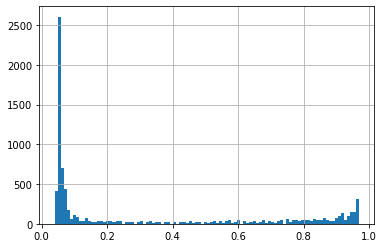

In [ ]:
submission = pd.concat([pd.read_csv(path) for path in glob(f'{CHECKPOINT_PATH}/node_submissions/*.csv')]).groupby('id').mean()
submission['toxic'].hist(bins=100)

In [ ]:
submission

,toxic
id,
0,0.835938
1,0.306641
2,0.906250
3,0.053467
4,0.060059
...,...
7995,0.047607
7996,0.968750
7997,0.933594


In [32]:
model_name='cnn_head2_0618_jigsaw1_2Tran_jigsaw1test'
val_lang='raw'
test_lang='raw'

In [ ]:
  del net
  torch.cuda.empty_cache()

In [33]:

bert_config = XLMRobertaConfig.from_pretrained('/content/drive/My Drive/Colab Notebooks/toxic_multi/xlm-roberta-large')
bert_config.output_hidden_states = True
bert_config.num_labels = 2
for i in range(4):
  FLAGS={}
  # xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

  net = ToxicSimpleNNModel(config=bert_config,head='cnn_head2')
  checkpoint = torch.load(f'{CHECKPOINT_PATH}/best_model.bin', map_location=torch.device('cpu'))
  net.load_state_dict(checkpoint)
  xmp.spawn(_mp_fn_fold_valid,args=(FLAGS,i,), nprocs=8, start_method='fork')
  del net
  torch.cuda.empty_cache()
  submission = pd.concat([pd.read_csv(path) for path in glob(f'{CHECKPOINT_PATH}/node_submissions/*_test.csv')]).groupby('id').mean()
  submission2 = pd.concat([pd.read_csv(path) for path in glob(f'{CHECKPOINT_PATH}/node_submissions/*_valid.csv')]).groupby('id').mean()
  submission.to_csv(f'{ROOT_PATH}/{model_name}_f{i}_test_{test_lang}.csv')
  submission2.to_csv(f'{ROOT_PATH}/{model_name}_f{i}_valid_{val_lang}.csv')
  shutil.rmtree(f'{CHECKPOINT_PATH}/node_submissions')

Model prepared. Device is xla:1
Fitter prepared. Device is xla:1
training fold 0


2020-06-19T03:13:19.605916
LR: 4e-05
Train Step 0, loss: 0.00000, final_score: 0.00000, time: 0.74721
[RESULT]: Train. Epoch: 0, loss: 0.32360, final_score: 0.94475, time: 110.76740
Valid Step 0, loss: 0.00000, final_score: 0.00000, time: 0.74682
best score with 0.9641734758013828 for 0
[RESULT]: Validation. Epoch: 0, loss: 0.31324, final_score: 0.96417, time: 42.14141

2020-06-19T03:15:52.541043
LR: 4e-05
Train Step 0, loss: 0.00000, final_score: 0.00000, time: 0.11041
[RESULT]: Train. Epoch: 1, loss: 0.30978, final_score: 0.96929, time: 58.72903
Valid Step 0, loss: 0.00000, final_score: 0.00000, time: 0.74557
best score with 0.9678189817724702 for 0
[RESULT]: Validation. Epoch: 1, loss: 0.31605, final_score: 0.96782, time: 7.90768
Prediction Step 0, time: 0.01060
Prediction Step 50, time: 21.57652
Prediction Step 100, time: 30.96727
Prediction Step 150, time: 40.35389
Prediction Step 200, time: 49.7964

In [34]:
submission = pd.concat([pd.read_csv(f'{ROOT_PATH}/{model_name}_f{i}_valid_{val_lang}.csv') for i in range(4)])


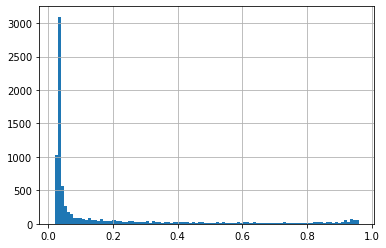

In [35]:
# submission = pd.concat([pd.read_csv(path) for path in glob(f'{CHECKPOINT_PATH}/node_submissions/*_0_*_test.csv')]).groupby('id').mean()
submission['toxic'].hist(bins=100)

In [36]:
submission = submission.sort_values(by='id').reset_index(drop=True)

In [37]:
submission

,id,toxic
0,0,0.140625
1,1,0.070312
2,2,0.753906
3,3,0.035645
4,4,0.030029
...,...,...
7995,7995,0.030151
7996,7996,0.957031
7997,7997,0.859375
7998,7998,0.028442


In [40]:
submission.sort_values(by='id').reset_index(drop=True).to_csv(f'{ROOT_PATH}/{model_name}_valid_{val_lang}.csv',index=False)

In [38]:
val = pd.read_csv(f'{ROOT_PATH}/input/validation.csv', index_col='id')

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(val['toxic'],submission['toxic'])

0.952560975609756

In [41]:

df_val = pd.read_csv(f'{ROOT_PATH}/input/validation.csv', index_col='id')

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=df_val,y=df_val[['lang','toxic']].values)):
  print(fold,roc_auc_score(df_val.loc[val_idx,'toxic'],submission.loc[val_idx,'toxic']))

0 0.9497242562402136
1 0.9602157594178871
2 0.950160750051467
3 0.9522896540843595


In [42]:
preds = None
for i in range(4):
  temp = pd.read_csv(f'{ROOT_PATH}/{model_name}_f{i}_test_{test_lang}.csv').rename(columns = {'toxic':f'toxic_f{i}'})
  if preds is None:
    preds = temp
  else:
    preds = preds.merge(temp,on='id',how='inner')
  

In [43]:
preds['toxic'] = preds[['toxic_f0','toxic_f1','toxic_f2','toxic_f3']].mean(axis=1)

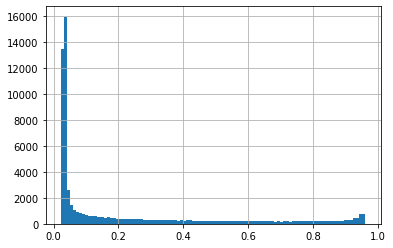

In [44]:
preds['toxic'].hist(bins=100)

In [45]:
preds

,id,toxic_f0,toxic_f1,toxic_f2,toxic_f3,toxic
0,0,0.030640,0.030396,0.031738,0.027954,0.030182
1,1,0.149414,0.043945,0.039307,0.111328,0.085999
2,2,0.300781,0.300781,0.306641,0.206055,0.278564
3,3,0.032227,0.029785,0.031982,0.026489,0.030121
4,4,0.035645,0.033203,0.035645,0.031250,0.033936
...,...,...,...,...,...,...
63807,63807,0.135742,0.109375,0.089844,0.072266,0.101807
63808,63808,0.033203,0.031982,0.035645,0.029297,0.032532
63809,63809,0.076172,0.068359,0.053955,0.049316,0.061951
63810,63810,0.032471,0.036133,0.032227,0.029053,0.032471


In [46]:
preds[['id','toxic']].to_csv(f'{ROOT_PATH}/{model_name}_test_{test_lang}.csv',index=False)

In [ ]:
preds

,id,toxic_f0,toxic_f1,toxic_f2,toxic_f3,toxic
0,0,0.039795,0.050293,0.041992,0.041992,0.043518
1,1,0.106934,0.106934,0.044678,0.101074,0.089905
2,2,0.281250,0.453125,0.371094,0.244141,0.337402
3,3,0.044678,0.056641,0.037354,0.047607,0.046570
4,4,0.044678,0.053467,0.037354,0.037354,0.043213
...,...,...,...,...,...,...
63807,63807,0.122559,0.207031,0.115723,0.112793,0.139526
63808,63808,0.050293,0.060059,0.041992,0.039795,0.048035
63809,63809,0.075684,0.106934,0.056641,0.067871,0.076782
63810,63810,0.044678,0.067871,0.039795,0.041992,0.048584


In [ ]:
import shutil
shutil.rmtree(f'{CHECKPOINT_PATH}/node_submissions')